## Why do we use Regression Analysis?

>Regression analysis estimates the relationship between two or more variables. Let’s understand this with an easy example:

Let’s say, you want to estimate growth in sales of a company based on current economic conditions. You have the recent company data which indicates that the growth in sales is around two and a half times the growth in the economy. Using this insight, we can predict future sales of the company based on current & past information.

There are multiple benefits of using regression analysis. They are as follows:

- It indicates the significant relationships between dependent variable and independent variable.
- It indicates the strength of impact of multiple independent variables on a dependent variable.

Regression analysis also allows us to compare the effects of variables measured on different scales, such as the effect of price changes and the number of promotional activities. These benefits help market researchers / data analysts / data scientists to eliminate and evaluate the best set of variables to be used for building predictive models.

Previously we have seen how to fit the simple linear regression to our data and how to fit the Polynomial regression using scikit learn. This extra higher degree feature dimensions that we added to our model are also known as **Polynomial Basis Functions**. 

It is also possible to create other basis functions. One pattern is to fit a model that is not sum of Polynomial bases but **Gaussian bases**. These Gaussian bases are not inbuilt to scikit-learn, so we need to write down our own function.

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    ''' Uniformly spaced Gaussian features for one-dimensional-input'''
    def __init__(self, N, width_factor = 2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def __gauss_basis(x, y, width, axis= None):
        arg = (x-y)/width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y = None):
        # Create the N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_  = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self.__gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis = 1)

In [37]:
gauss_model = make_pipeline(GaussianFeatures(15), LinearRegression())

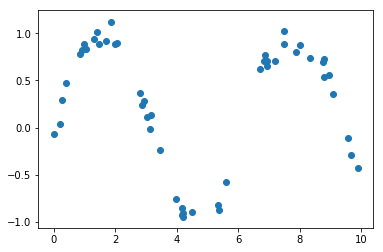

In [10]:
# Let's create our own dataset

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

plt.scatter(x, y)

> Since we know our data is not a straight line, we need to find the right degree of polynomial to not overfit the model. We will use **GridsearchCV**.

In [11]:
# Our polynomial Regression model

def PolynomialRegression(degree = 2, **kwargs):
     return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [17]:
# Let's first use the validation curve to predict the right degree
x = x.reshape(len(x), 1) # Preparing the x form 1D to 2D for sklearn


from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), x, y, 'polynomialfeatures__degree', degree, cv = 7)

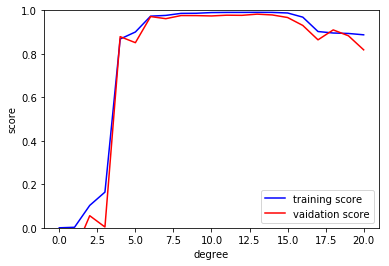

In [18]:
plt.plot(degree, np.median(train_score, axis = 1), color = 'b', label = 'training score')
plt.plot(degree, np.median(val_score, axis = 1), color = 'r', label = 'vaidation score')
plt.legend(loc = 'best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')
plt.show()

From the validation curve it should be somewhere near to 7. Let's confirm it!

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept':[True, False],
    'linearregression__normalize': [True, False]
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv = 7)
# Note this has not been applied to any data

grid.fit(x, y)

GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
# Now we can ask for best parameters

grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 10}

In [26]:
poly_model = grid.best_estimator_

In [31]:
xfit = np.linspace(0, 10, 1000)
xfit = xfit.reshape(len(xfit), 1)
poly_model.fit(x, y)
yfit = poly_model.predict(xfit)

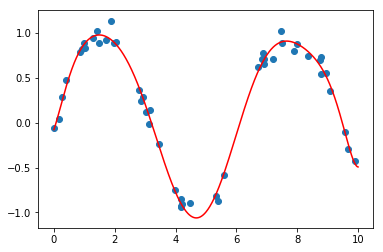

In [33]:
plt.scatter(x, y)
plt.plot(xfit, yfit, c = 'r')

In [38]:
# Now we will use gauss_model that we created to check if we are getting the best fit

gauss_model.fit(x, y)
yfit = gauss_model.predict(xfit)

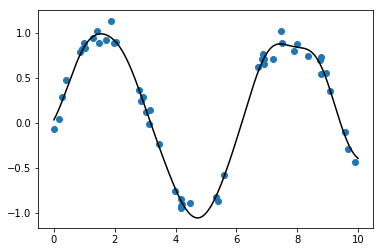

In [91]:
plt.scatter(x, y)
plt.plot(xfit, yfit, c = 'k')

Though basis functions are very useful for complex data but they are prone to overfitting. As you might have known by this time, more is the high order polynomials, more complex model we can create. So one approach is to penalize the higher order polynomials, not to capture all the variance.

In [41]:
gauss_model = make_pipeline(GaussianFeatures(35), LinearRegression())
gauss_model.fit(x, y)
yfit = gauss_model.predict(xfit)

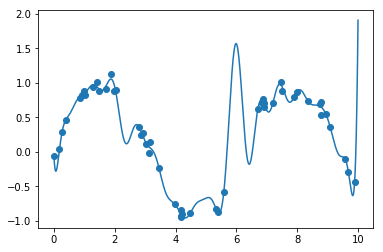

In [42]:
plt.scatter(x, y)
plt.plot(xfit, yfit)

## Ridge Regression(L2 regularization)

Also known as Tikhonov Regularization. You can implement it by taking sum of square of two norms. We will see how scikit-learn is helping you to implement the ridge regression.

In [79]:
from sklearn.linear_model import Ridge
model_l2 = make_pipeline(GaussianFeatures(30), Ridge(alpha = 0.1))

In [80]:
model_l2.fit(x, y)
yfit = model_l2.predict(xfit)

Text(0.5,1,'Ridge Regression')

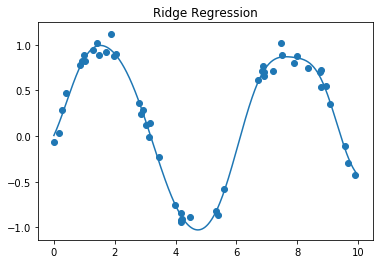

In [81]:
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.title('Ridge Regression')

> We can clearly see how 30 degree gaussian basis is not overfitting the model. More is the value of alpha more smooth curve we will get. Try the following value of alpha to your model and check the result- 
- alpha = 0.00001 --> you should see the model is still overfitting
- alpha = 0.8 ----> The curve is more smoothen

Ridge Regression is very fast to implement and the most common regularizer.

## Lasso Regression(L1)

Another very common type of regularization is L1 regularization and in Lasso instead of taking the sum of squares we will take the sum of absolute values. Lasso regression favors sparse models due to geometric reasons. 

In [85]:
from sklearn.linear_model import Lasso
model_l1 = make_pipeline(GaussianFeatures(30), Lasso(alpha = 0.001))

In [86]:
model_l1.fit(x, y)
yfit = model_l1.predict(xfit)

c:\users\ranja\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0.5,1,'Lasso Regression')

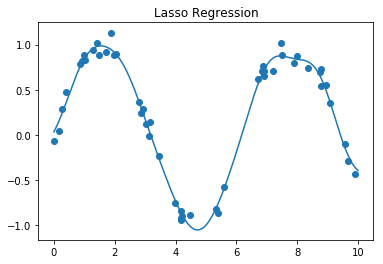

In [87]:
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.title('Lasso Regression')

## ElasticNet Regression

ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

In [88]:
# Try this as homework
from sklearn.linear_model import ElasticNet